In [16]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

import pytesseract
from PIL import Image

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

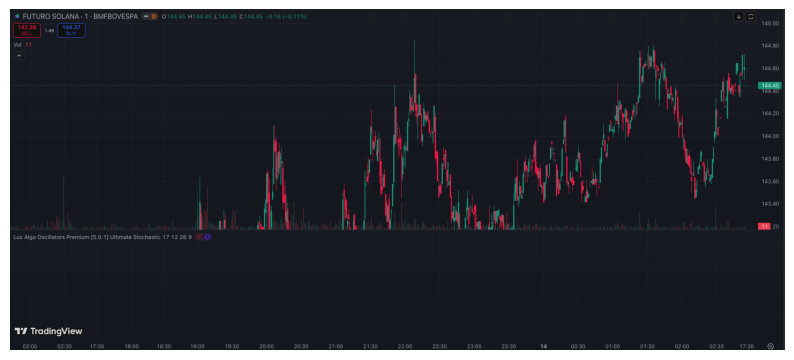

In [17]:
plt.style.use("seaborn-v0_8-darkgrid")

IMAGE_PATH = "../data/sample_chart.png"

img_bgr = cv2.imread(IMAGE_PATH)
if img_bgr is None:
    raise ValueError("Failed to load image")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

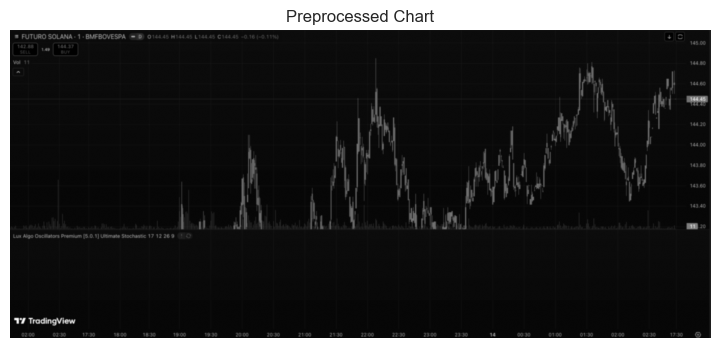

In [18]:
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

plt.figure(figsize=(10, 4))
plt.imshow(blur, cmap="gray")
plt.title("Preprocessed Chart")
plt.axis("off")

(np.float64(-0.5), np.float64(1809.5), np.float64(795.5), np.float64(-0.5))

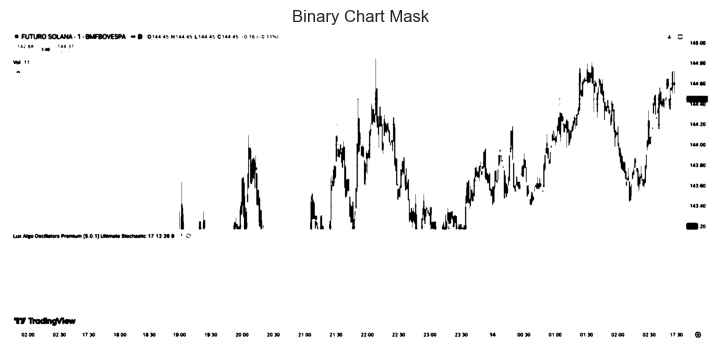

In [19]:
thresh = threshold_otsu(blur)
binary = blur < thresh

plt.figure(figsize=(10, 4))
plt.imshow(binary, cmap="gray")
plt.title("Binary Chart Mask")
plt.axis("off")

In [20]:
height, width = binary.shape

price_pixels = []

for x in range(width):
    column = np.where(binary[:, x])[0]
    if len(column) > 0:
        price_pixels.append(np.mean(column))
    else:
        price_pixels.append(np.nan)

price_pixels = pd.Series(price_pixels).interpolate().to_numpy()

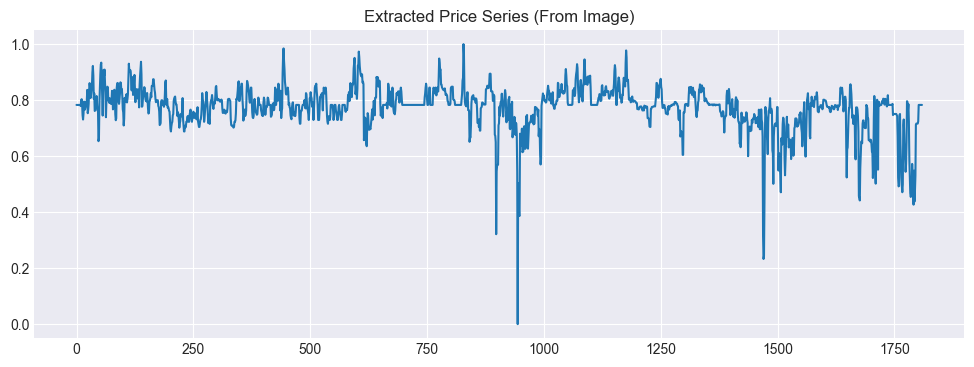

In [21]:
price_series = (height - price_pixels)
price_series = (price_series - price_series.min()) / (price_series.max() - price_series.min())

plt.figure(figsize=(12, 4))
plt.plot(price_series)
plt.title("Extracted Price Series (From Image)")
plt.show()

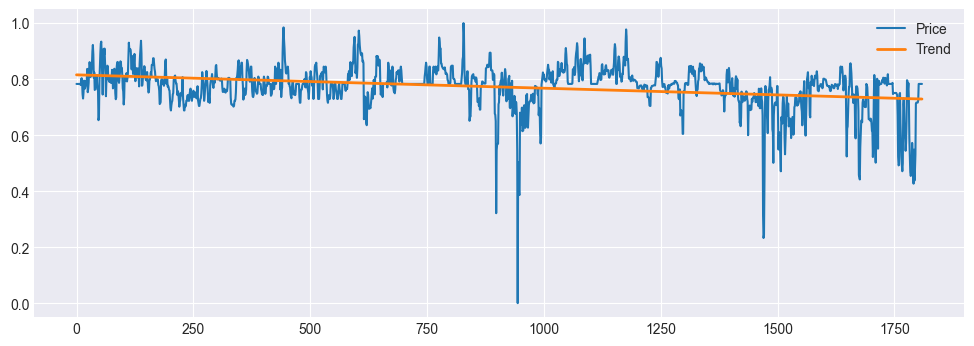

In [22]:
X = np.arange(len(price_series)).reshape(-1, 1)
y = price_series.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)

trend_line = model.predict(X).flatten()
trend_slope = model.coef_[0][0]

plt.figure(figsize=(12, 4))
plt.plot(price_series, label="Price")
plt.plot(trend_line, label="Trend", linewidth=2)
plt.legend()
plt.show()

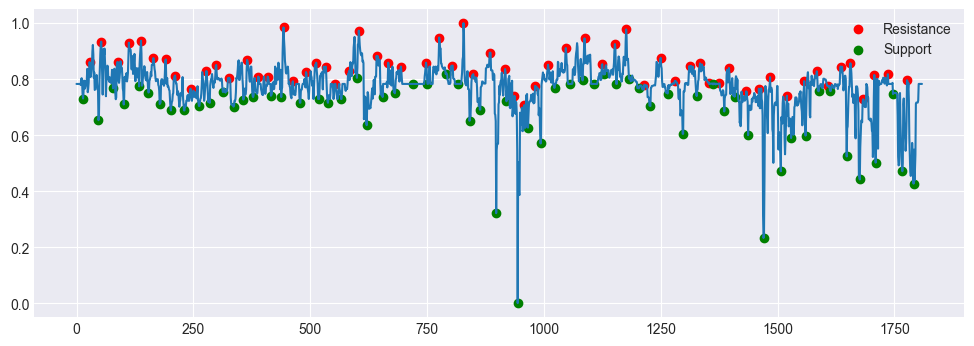

In [23]:
peaks, _ = find_peaks(price_series, distance=20)
troughs, _ = find_peaks(-price_series, distance=20)

resistance = price_series[peaks]
support = price_series[troughs]

plt.figure(figsize=(12, 4))
plt.plot(price_series)
plt.scatter(peaks, resistance, color="red", label="Resistance")
plt.scatter(troughs, support, color="green", label="Support")
plt.legend()
plt.show()

In [24]:
returns = np.diff(price_series)
volatility = np.std(returns)

volatility

np.float64(0.04339117019931653)

In [ ]:
if trend_slope > 0.002:
    trend_label = "Bullish Trend"
elif trend_slope < -0.002:
    trend_label = "Bearish Trend"
else:
    trend_label = "Sideways / Range-bound"

if volatility > 0.015:
    vol_label = "High Volatility"
else:
    vol_label = "Low Volatility"

In [ ]:
bias = {}

if trend_label == "Bullish Trend":
    bias["direction"] = "Long Bias"
elif trend_label == "Bearish Trend":
    bias["direction"] = "Short Bias"
else:
    bias["direction"] = "Mean Reversion / Range Trades"

bias["risk"] = "Reduce size" if vol_label == "High Volatility" else "Normal size"

In [ ]:
print("---- TRADING ANALYSIS SUMMARY ----")
print("=" * 40)
print(f"Trend           : {trend_label}")
print(f"Volatility      : {vol_label}")
print(f"Trend Slope     : {trend_slope:.5f}")
print(f"Volatility Std  : {volatility:.5f}")
print()
print("---- TRADING BIAS ----")
print(f"Direction       : {bias['direction']}")
print(f"Risk Management : {bias['risk']}")